# Basic introduction to working with maps

# Introduction

This tutorial gives a basic introduction to working with gammapy maps, how to fill and visualise data. `gammapy.maps` contains classes to deal with representing pixelized data structures with at least two spatial dimensions representing coordinates on a sphere (e.g. an image in celestial coordinates). This can deal with images (2D), cubes (3D) and hyercubes (3+D).

More options to be added as the structure is developed; please see http://docs.gammapy.org/dev/maps/index.html for the latest developments

# Setup

Import the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gammapy.data import DataStore
from astropy.coordinates import SkyCoord
from gammapy.maps import Map, MapAxis, WcsGeom, WcsNDMap, MapCoord
import astropy.units as u
from gammapy.cube import fill_map_counts, MapMaker

# Data selection

We will use one Sgr A* run from the gammapy extra dataset.

In [2]:
#source_pos = SkyCoord.from_name("Sgr A*")
source_pos = SkyCoord(266.41681663, -29.00782497, unit="deg")
ds=DataStore.from_dir("$GAMMAPY_EXTRA/datasets/cta-1dc/index/gps/")
obs=ds.obs(110380)
evts=obs.events

The available columns in the event file can be easily seen. The axes of the maps should be chosen from among these names.

In [3]:
evts.table.colnames

['EVENT_ID', 'TIME', 'RA', 'DEC', 'ENERGY', 'DETX', 'DETY', 'MC_ID']

# Instantiating the Map geometry

The most common use case is likely to be 3D maps, maps with 2 spatial and one energy dimension. However, there can be many other axes as well, eg: time, phase, telescope type, etc. 

Here, we will create one 3D map, and, just for example, one 4D map (with energy and MC_ID as the non-spatial dimension)

The MapAxis class is used to to create the map axis.

In [4]:
binsz = 0.05 
energy_axis = MapAxis.from_bounds(0.5,50.0,10,name='energy',unit='TeV',interp='log')
mc_axis=MapAxis.from_edges([0,500,1000,1750], interp="lin", name='MC_ID')


A variable bin size can also be put on for different axis, in that case, binsize should be an array of the same dimension, eg:

In [5]:
binsz_var = np.sqrt((3.0*(energy_axis.center/100.)**-0.8)**2 + 0.1**2)

The WcsGeom class will create the required wcs geometry, a geom object

In [6]:
geom3d = WcsGeom.create(binsz=binsz, skydir=source_pos, width=15.0,
                       axes=[energy_axis])
geom4d = WcsGeom.create(binsz=binsz, skydir=source_pos, width=(20.0, 15), axes=[energy_axis, mc_axis])

The axes details can be accessed from within the geom object, and the map coordinates for each pixel using the get_coord()

In [7]:
[_.name for _ in geom4d.axes]

['energy', 'MC_ID']

In [8]:
map4d_coord=geom4d.get_coord()

In [9]:
lat_cord=map4d_coord.lat

# Filling the Map 

Now, we create a map object and fill it the events

In [10]:
map3d = WcsNDMap.from_geom(geom=geom3d,unit='')
map4d = WcsNDMap.from_geom(geom=geom4d,unit='')

In [11]:
fill_map_counts(map3d,evts)
fill_map_counts(map4d,evts)

# Exploring maps

A `repr` of the maps can be easily obtained

In [12]:
map4d.geom

WcsGeom

	npix      : 400 x 300 pix
	coordsys  : CEL
	projection: CAR
	center    : 266.4 deg, -29.0 deg
	width     : 20.0 x 15.0 deg
	ndim      : 4
	axes      : energy, MC_ID

For a given source pos, the pixel position in the map can be obtained using 
coord_to_pix(). The geom.to_image() will give create a 2D geometry by dropping all non-spatial dimensions of this
geometry.

In [13]:
pix_lon,pix_lat=map4d.geom.to_image().coord_to_pix(source_pos)

The map has (N+2)D dimensions, where the last 2 dimensions are the spatial ones. The shape of the the rest N dimensions in the geom object can be seen using the shape parameter

In [14]:
geom4d.shape

(10, 3)

In the map object, the non spatial dimensions are transposed

In [15]:
map4d.data.shape

(3, 10, 300, 400)

This is because the data members have a column major ordering following the FITS convention (making it easier to read and write files using astropy.io.fits. On the other hand, the accessor methods have a row major ordering according to the convention is astrophy.wcs. Thus, the map geometry has the last two axes as the spatial ones in (lon, lat) whereas the map has the spatial axes ordered as (lat, lon). Note that the spatial axes are always the last 2 axes.

In [16]:
map4d.geom

WcsGeom

	npix      : 400 x 300 pix
	coordsys  : CEL
	projection: CAR
	center    : 266.4 deg, -29.0 deg
	width     : 20.0 x 15.0 deg
	ndim      : 4
	axes      : energy, MC_ID

In [17]:
map4d

WcsNDMap

	geom      : WcsGeom 
 	unit      :  
	data shape: (3, 10, 300, 400)
	data mean : 2.6e-03 
	data min  : 0.0e+00 
	data max  : 6.0e+00 

Each spatial slice can be extracted in a variety of ways
(i) by specifying the slice indices - get_image_by_idx()
(ii) by specifying the values at which the slice is required - get_image_by_coord
(iii) by specifying the pixels - get_image_by_pix()

In [18]:
map4d_slice = map4d.get_image_by_idx([0,0])
map4d_slice = map4d.get_image_by_coord({'energy': '500 GeV', 'MC_ID': '2'})

The images can then be plotted

(<matplotlib.figure.Figure at 0x7f149697c1d0>,
 None)

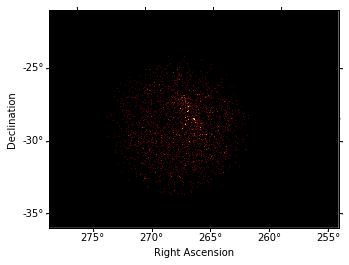

In [19]:
map4d_slice.plot()

This map does not really convey a lot, so we will first make a spatial cutout on our region of interest, and then smooth before plotting for a better visualisation 

In [20]:
map4d_cutout = map4d.cutout(position=source_pos, width=8.0*u.deg)

In [21]:
map4d_cutout

WcsNDMap

	geom      : WcsGeom 
 	unit      :  
	data shape: (3, 10, 160, 160)
	data mean : 1.1e-02 
	data min  : 0.0e+00 
	data max  : 6.0e+00 

(<matplotlib.figure.Figure at 0x7f1496285400>,
 <matplotlib.colorbar.Colorbar at 0x7f1495d54940>)

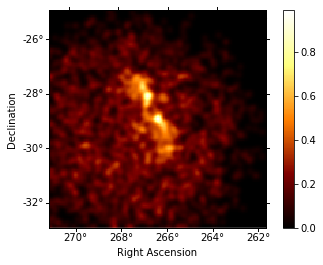

In [22]:
map4d_slice=map4d_cutout.get_image_by_coord({'energy': '500 GeV', 'MC_ID': '2'})
map4d_slice.smooth(radius=0.2*u.deg,kernel="gauss").plot(add_cbar=True)

# Reprojecting maps onto a different geometry

It is often useful to reproject the maps onto different geometries. Here, we will reproject our map onto a Galactic Coordinate system

In [23]:
geom_rep = WcsGeom.create(binsz=binsz, skydir=source_pos,coordsys="GAL", width=15.0,axes=[energy_axis, mc_axis])
map_rep = map4d.reproject(geom_rep)

(<matplotlib.figure.Figure at 0x7f1495278240>,
 None)

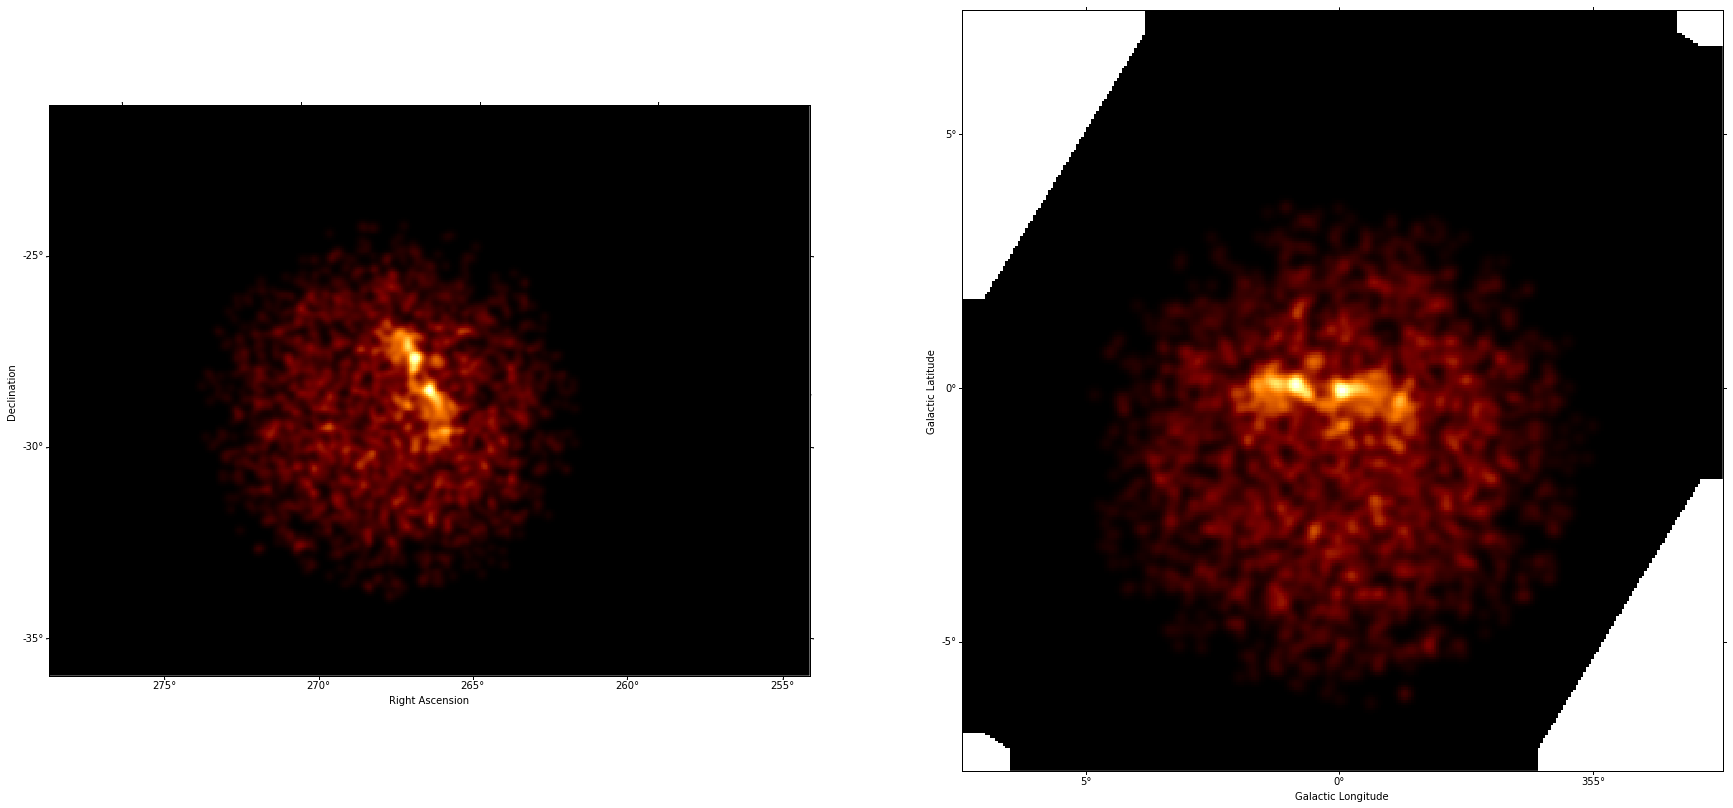

In [24]:
fig = plt.figure(figsize=(30,20))
ax1=fig.add_subplot(121,projection=geom4d.wcs)
map4d.get_image_by_coord({'energy': '500 GeV', 'MC_ID': '2'}).smooth(radius=0.2*u.deg,kernel="gauss").plot(ax=ax1)

ax2=fig.add_subplot(122,projection=geom_rep.wcs)
map_rep.get_image_by_coord({'energy': '500 GeV', 'MC_ID': '2'}).smooth(radius=0.2*u.deg,kernel="gauss").plot(ax=ax2)

# Reading images from fits files

It is very simple to read fits files from already prepared data sets as well.
As an example, we will read a FITS file from a prepared Fermi-LAT 2FHL dataset:

In [25]:
vela_2fhl = WcsNDMap.read("$GAMMAPY_EXTRA/datasets/fermi_2fhl/fermi_2fhl_vela.fits.gz", hdu='COUNTS')

We can see the geometry and the shape of the map

In [26]:
vela_2fhl

WcsNDMap

	geom      : WcsGeom 
 	unit      :  
	data shape: (180, 320)
	data mean : 2.7e-02 
	data min  : 0.0e+00 
	data max  : 4.0e+00 

In [27]:
vela_2fhl.geom

WcsGeom

	npix      : 320 x 180 pix
	coordsys  : GAL
	projection: CAR
	center    : 266.0 deg, -1.2 deg
	width     : 32.0 x 18.0 deg
	ndim      : 2
	axes      : 

Since this is a 2D map in the first place, we can make some nice plots (no slicing required)

(<matplotlib.figure.Figure at 0x7f149526b710>,
 None)

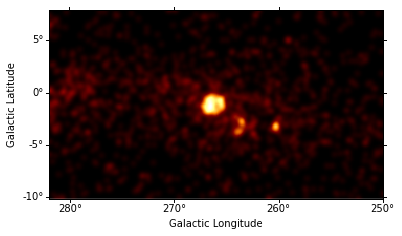

In [28]:
vela_2fhl.smooth(kernel='gauss', radius=0.5 * u.deg).plot()

# Plotting contours

Lets try to plot some contours now! We will read a second image containing WMAP data from the same region, and overlay WMAP contours on top of the Fermi image. 

In [29]:
vela_wmap = WcsNDMap.read("$GAMMAPY_EXTRA/datasets/images/Vela_region_WMAP_K.fits")
vela_wmap.geom

WcsGeom

	npix      : 300 x 300 pix
	coordsys  : CEL
	projection: TAN
	center    : 128.5 deg, -45.8 deg
	width     : 30.0 x 30.0 deg
	ndim      : 2
	axes      : 

As you can see, these two images have a different geometry. This is where reprojection comes in handy

In [30]:
vela_wmap_rep = vela_wmap.reproject(vela_2fhl.geom)

In [31]:
vela_2fhl

WcsNDMap

	geom      : WcsGeom 
 	unit      :  
	data shape: (180, 320)
	data mean : 2.7e-02 
	data min  : 0.0e+00 
	data max  : 4.0e+00 

In [32]:
vela_pos = vela_2fhl.geom.center_skydir

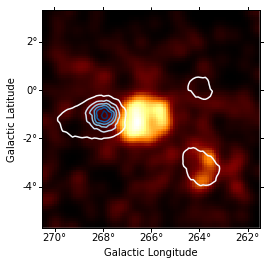

In [33]:
vela_cutout = vela_2fhl.cutout(vela_pos, width=9.0 * u.deg)
vela_rep_cut = vela_wmap_rep.cutout(vela_pos, width=9.0 * u.deg)
fig, ax, _ = vela_cutout.smooth(kernel='gauss', radius=0.5 * u.deg).plot()
ax.contour(vela_rep_cut.data, cmap='Blues')

# What next?

The tutorial `simulate_3d` shows how to simulate and fit maps simultaneously with spatial and spectral models

For more details on maps, eg: working with HEALPix maps, visit the documentation at http://docs.gammapy.org/dev/maps/index.html

# Exercises

1. Play around with the 3D map we created - take a cutout, reproject onto different geometries, smooth and plot.
2. Make a map with a variable binsize